## Homework_2
#### 011720209-陈航

##### 一枚炮弹在海平面上方100m处的悬崖上以水平500m/s的速度射出，假设$v_y0=0$、$p_0=100m$，$a_x$为炮弹离开炮管后水平方向的加速度，因为无外力作用，所以$a_x=0$，$v_x0=500m/s$，$p_0$可以设为零

##### 注：此文档内的Adams法为四阶Adams法，与四阶Runge-Kutta法适用于仿真步长为整数或两位小数的情况，若仿真步长为其他情况，可直接在相应函数体内调整round()函数的小数保留参数

In [784]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

引入单位和定义常量

In [785]:
m=UNITS.meter
s=UNITS.second

g=9.8*m/s**2
dt=1*s

1 <Unit('second')>

实现四阶Adams方法

In [786]:
def run_adams(system,slope_func):
    
    #the default message if nothing changes
    msg="The solver successfully reached the end of the integration interval."
    
    #get parameters from system
    init=system.init
    t_0=system.t_0
    t_end=system.t_end
    system.t_end=dt*4
    
    #make the TimeFrame
    frame,details=run_euler(system,slope_func)
    ts=linrange(t_0+dt*3,t_end,dt)*get_units(t_end)
    system.t_end=t_end

    #run the solver
    for t1 in ts:
        y1=frame.row[round(t1,2)]
        slopes=slope_func(y1,round(t1,2),system)
        y2=[y+55/24*slope*dt for y,slope in zip(y1,slopes)]
        
        y1=frame.row[round(t1-dt,2)]
        slopes=slope_func(y1,round(t1-dt,2),system)
        y2=[y-59/24*slope*dt for y,slope in zip(y2,slopes)]
        
        y1=frame.row[round(t1-dt*2,2)]
        slopes=slope_func(y1,round(t1-dt*2,2),system)
        y2=[y+37/24*slope*dt for y,slope in zip(y2,slopes)]
        
        y1=frame.row[round(t1-dt*3,2)]
        slopes=slope_func(y1,round(t1-dt*3,2),system)
        y2=[y-9/24*slope*dt for y,slope in zip(y2,slopes)]
        
        t2=round(t1+dt,2)
        frame.row[t2]=y2

    return frame

定义误差计算函数，即判断假设的运动结束时间时，炮弹的最终高度

In [787]:
def erro(t_end,system):
    system.t_end=t_end
    results=run_adams(system,slope_func_z)
    return get_last_value(results.h)

定义x、z两方向各自的斜率函数

In [788]:
def slope_func_z(state,t,system):
    h,vz=state
    dh=vz
    dvz=-system.a
    return dh,dvz

In [789]:
def slope_func_x(state,t,system):
    x,vx=state
    dx=vx
    dvx=0.0*m/s**2
    return dx,dvx

定义系统初始化函数

In [790]:
def make_sys(state,t_0,t_end,dt,a):
    return System(init=state,t_0=t_0,t_end=t_end,dt=dt,a=a)

假设运动结束时间为6s，计算此时炮弹的最终高度

In [791]:
init_z=State(h=100*m,vz=0*m/s)
init_x=State(x=0*m,vx=500*m/s)
t_end=6.0*s
system_z=make_sys(init_z,0*s,t_end,dt,g)
erro(t_end,system_z)

-61.69999999999998 <Unit('meter')>

由于此时炮弹的最终高度低于地平面，则运动的真实结束时间为6s以前，因此以高度在地平面的时刻作为真实结束时间

In [792]:
ts=linrange(0*s,t_end,dt)
results=run_adams(system_z,slope_func_z)
for t in ts:
    if results.row[round(t,2)].h<0*m:
        t_end=round(t,2)*s
        break

以Euler方法实现数值仿真，绘出z方向高度变化图

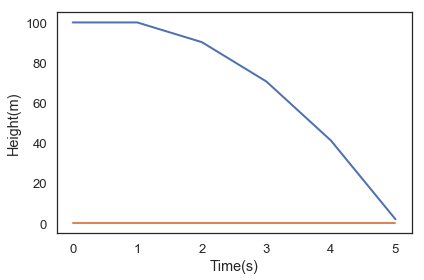

In [793]:
system_x=make_sys(init_x,0*s,t_end,dt,g)
system_z=make_sys(init_z,0*s,t_end,dt,g)
results_z_euler,details_z=run_euler(system_z,slope_func_z)
results_x_euler,details_x=run_euler(system_x,slope_func_x)
plot(results_z_euler.h)
decorate(xlabel='Time(s)',ylabel='Height(m)')

x=[0,1,2,3,4,5]
y=[0,0,0,0,0,0]
plot(x,y)

绘出x方向距离变化图

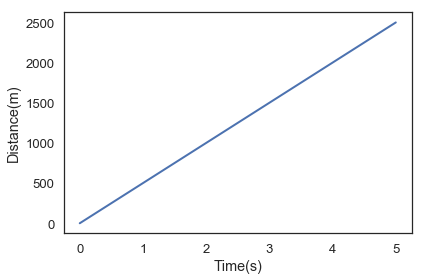

In [794]:
plot(results_x_euler.x)
decorate(xlabel='Time(s)',ylabel='Distance(m)')

以四阶Adams方法实现数值仿真，绘出z方向高度变化图

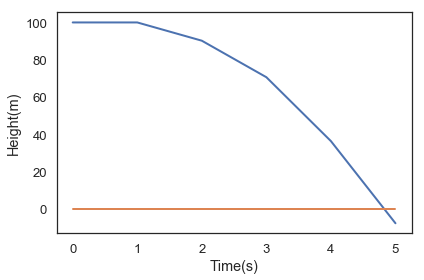

In [795]:
system_x=make_sys(init_x,0*s,t_end,dt,g)
system_z=make_sys(init_z,0*s,t_end,dt,g)
results_x_adams=run_adams(system_x,slope_func_x)
results_z_adams=run_adams(system_z,slope_func_z)
plot(results_z_adams.h)
decorate(xlabel='Time(s)',ylabel='Height(m)')

x=[0,1,2,3,4,5]
y=[0,0,0,0,0,0]
plot(x,y)

绘出x方向距离变化图

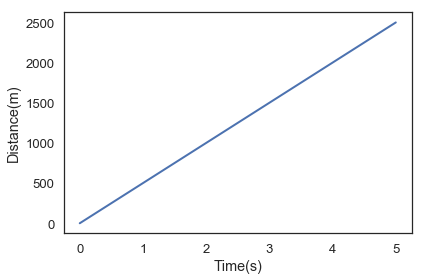

In [796]:
plot(results_x_adams.x)
decorate(xlabel='Time(s)',ylabel='Distance(m)')

实现四阶Runge-Kutta方法

In [797]:
def run_rk4(system,slope_func):
    
    #the default message if nothing changes
    msg="The solver successfully reached the end of the integration interval."
    
    #get parameters from system
    init=system.init
    t_0=system.t_0
    t_end=system.t_end
    system.t_end=dt*4
    
    #make the TimeFrame
    frame,details=run_euler(system,slope_func)
    ts=linrange(t_0+dt*3,t_end,dt)*get_units(t_end)
    system.t_end=t_end

    #run the solver
    for t1 in ts:
        y1=frame.row[round(t1,2)]
        slopes=slope_func(y1,round(t1,2),system)
        y_0=[y+1/6*slope*dt for y,slope in zip(y1,slopes)]
        
        y2=[y+1/6*slope*dt/2 for y,slope in zip(y1,slopes)]
        slopes=slope_func(y2,round(t1+dt/2,2),system)
        y_0=[y+2/6*slope*dt for y,slope in zip(y_0,slopes)]
        
        y3=[y+2/6*slope*dt/2 for y,slope in zip(y1,slopes)]
        slopes=slope_func(y3,round(t1+dt/2,2),system)
        y_0=[y+2/6*slope*dt for y,slope in zip(y_0,slopes)]
        
        y4=[y+2/6*slope*dt for y,slope in zip(y1,slopes)]
        slopes=slope_func(y4,round(t1+dt,2),system)
        y_0=[y+1/6*slope*dt for y,slope in zip(y_0,slopes)]
        
        t2=round(t1+dt,2)
        frame.row[t2]=y_0

    return frame

以四阶Runge-Kutta方法实现数值仿真，绘出z方向高度变化图

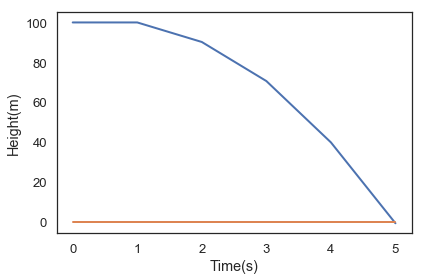

In [801]:
system_x=make_sys(init_x,0*s,t_end,dt,g)
system_z=make_sys(init_z,0*s,t_end,dt,g)
results_x_rk4=run_rk4(system_x,slope_func_x)
results_z_rk4=run_rk4(system_z,slope_func_z)
plot(results_z_rk4.h)
decorate(xlabel='Time(s)',ylabel='Height(m)')

x=[0,1,2,3,4,5]
y=[0,0,0,0,0,0]
plot(x,y)

绘出x方向距离变化图

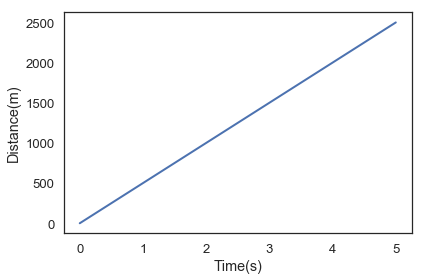

In [799]:
plot(results_x_rk4.x)
decorate(xlabel='Time(s)',ylabel='Distance(m)')

以Euler方法、四阶Adams方法和四阶Runge-Kutta方法实现数值仿真，在同一张图上绘出z方向高度变化图

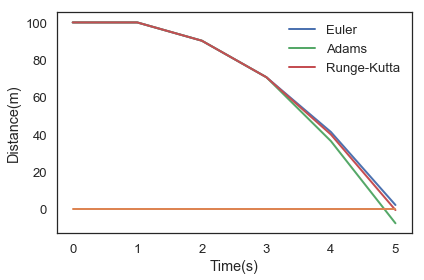

In [800]:
plot(results_z_euler.h,label='Euler')
plot(results_z_adams.h,label='Adams',color='C2')
plot(results_z_rk4.h,label='Runge-Kutta',color='C3')
decorate(xlabel='Time(s)',ylabel='Distance(m)')

x=[0,1,2,3,4,5]
y=[0,0,0,0,0,0]
plot(x,y)

##### 根据解析解法，该炮弹发射问题的真实结束时间t=4.52s。
##### 因此，由图可知，三种数值积分的精度从高到低为四阶Adams、四阶Runge-Kutta与Euler。